In [15]:
#pip install mendeleev
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
from mendeleev import element
import math

In [16]:
##creating Atom class
class Atom:
    def __init__(self, atType, symbol, userNum, coords, id = -1):
        self.atType = atType
        self.symbol = symbol
        self.userNum = userNum
        self.coords = coords
        self.id = id
        xyz = coords.split()
        self.xcoord = float(xyz[0])
        self.ycoord = float(xyz[1])
        self.zcoord = float(xyz[2])
        
    def __repr__(self):
        return "Atom: id: {}, atType: {}, symbol: {}, userNum: {}, coords: {}".format(self.id, self.atType, self.symbol, self.userNum, self.coords)

##creating Bond class
class Bond:
    def __init__(self, bondAtom1, bondAtom2, bondOrderType, bondOrder):
        self.bondAtom1 = bondAtom1
        self.bondAtom2 = bondAtom2
        self.bondOrderType = bondOrderType
        self.bondOrder = bondOrder
        
    def __repr__(self):
        return " Bond: bondAtom1: {}, bondAtom2: {}, bondOrderType: {}, bondOrder: {}".format(self.bondAtom1, self.bondAtom2, self.bondOrderType, self.bondOrder)

##creating Molecule class
class Molecule:
    
    ##initializer with option to parse c3xml file
    def __init__(self, file=None):
        self.atoms = dict()
        self.bonds = dict()
        if file == None:
            pass
            ##creates empty molecule, atoms and bonds can be added later on
        else:
            tree = ET.parse(file)
            root = tree.getroot()
            for atom in root.iter('atom'):
                id = atom.attrib['id']
                atType = atom.attrib['atType']
                symbol = atom.attrib['symbol']
                userNum = atom.attrib['userNum']
                coords = atom.attrib['cartCoords']
                self.atoms[id] = Atom(atType, symbol, userNum, coords, id)
            for bond in root.iter('bond'):
                id = bond.attrib['id']
                bondAtom1 = bond.attrib['bondAtom1']
                bondAtom2 = bond.attrib['bondAtom2']
                bondOrderType = bond.attrib['bondOrderType']
                bondOrder = bond.attrib['bondOrder']
                self.bonds[id] = Bond(bondAtom1, bondAtom2, bondOrderType, bondOrder)
        self.center = None
        #only for k-hop function
    
    def __repr__(self):
        return "Atoms: {}, Bonds: {}".format(self.atoms.keys(), self.bonds.keys())
    
    def bond_atom1(self, bond):
        return self.bonds[bond].bondAtom1
    
    def bond_atom2(self, bond):
        return self.bonds[bond].bondAtom2
    
    def bond_atom1_info(self, bond):
        return self.atoms[self.bonds[bond].bondAtom1]
    
    def bond_atom2_info(self, bond):
        return self.atoms[self.bonds[bond].bondAtom2]
    
    def plot(self):
        fig = plt.figure(figsize = (20,15))
        ax = plt.axes(projection = '3d')
    
        x = np.array([])
        y = np.array([])
        z = np.array([])
        
        symbol_colors = {'C': 'black', 'H': 'gray', 'O': 'red', 'N': 'blue', "Cl": 'green', 'S': 'yellow', 'P': 'orange', 'F': 'indigo'}
        
        atoms_dict_x = dict()
        atoms_dict_y = dict()
        atoms_dict_z = dict()
        for atom in self.atoms:
            if self.atoms[atom].symbol not in atoms_dict_x.keys():
                atoms_dict_x[self.atoms[atom].symbol] = np.array([])
                atoms_dict_y[self.atoms[atom].symbol] = np.array([])
                atoms_dict_z[self.atoms[atom].symbol] = np.array([])
            else:
                pass
            atoms_dict_x[self.atoms[atom].symbol] = np.append(atoms_dict_x[self.atoms[atom].symbol], self.atoms[atom].xcoord)
            atoms_dict_y[self.atoms[atom].symbol] = np.append(atoms_dict_y[self.atoms[atom].symbol], self.atoms[atom].ycoord)
            atoms_dict_z[self.atoms[atom].symbol] = np.append(atoms_dict_z[self.atoms[atom].symbol], self.atoms[atom].zcoord)
        for symbol in atoms_dict_x.keys():
            if symbol != 'Lp':
                if symbol in symbol_colors.keys():
                    color = symbol_colors[symbol]
                else:
                    color = 'magenta'
                size = 5 * element(symbol).atomic_radius
                ax.scatter(atoms_dict_x[symbol], atoms_dict_y[symbol], atoms_dict_z[symbol], s = size, c = color)
        ##plotting atoms
    
        bond_width = {'0':0,'1': 2, "2":6, "3":12}
        #none, single bond, double bond, triple bond
        for bond in self.bonds:
            xb = np.array([])
            yb = np.array([])
            zb = np.array([])
            xb = np.append(xb, self.atoms[self.bonds[bond].bondAtom1].xcoord)
            xb = np.append(xb, self.atoms[self.bonds[bond].bondAtom2].xcoord)
            yb = np.append(yb, self.atoms[self.bonds[bond].bondAtom1].ycoord)
            yb = np.append(yb, self.atoms[self.bonds[bond].bondAtom2].ycoord)
            zb = np.append(zb, self.atoms[self.bonds[bond].bondAtom1].zcoord)
            zb = np.append(zb, self.atoms[self.bonds[bond].bondAtom2].zcoord)
            ax.plot(xb, yb, zb, linewidth = bond_width[self.bonds[bond].bondOrder], c = 'gray')
        
    
    ##returns atoms & bonds one hop from given atom, used later to construct the k-hop method
    def one_hop(self, atom):
        one_hop = []
        one_hop.append(atom)
        one_hop_bonds = []
        for bond in self.bonds.keys():
            if self.bond_atom1(bond) == atom:
                one_hop.append(self.bond_atom2(bond))
                one_hop_bonds.append(bond)
            elif self.bond_atom2(bond) == atom:
                one_hop.append(self.bond_atom1(bond))
                one_hop_bonds.append(bond)
        return one_hop, one_hop_bonds
    
    ##built this first to use as a guide to build k-hop method
    #def two_hop(self, atom):
        #atoms, bonds = self.one_hop(atom)
        #two_hop = []
        #two_hop_bonds = []
        #for atom in atoms:
            #two_hop.append(atom)
        #for bond in bonds:
            #two_hop_bonds.append(bond)
        #for i in atoms:
            #a, b = self.one_hop(i)
            #for atom in a:
                #if atom not in two_hop:
                    #two_hop.append(atom)
            #for bond in b:
                #if bond not in two_hop_bonds:
                    #two_hop_bonds.append(bond)
        #return two_hop, two_hop_bonds
    
    ##returns molecule with all atoms, bonds in a k-hop neighborhood of an atom
    def k_hop(self, atom, k):
        k_atoms, k_bonds = self.one_hop(atom)
        new_atoms = []
        new_bonds = []
        for iter in range(k-1):
            for i in k_atoms:
                atoms, bonds = self.one_hop(i)
                for atom in atoms:
                    if atom not in k_atoms and atom not in new_atoms:
                        new_atoms.append(atom)
                for bond in bonds:
                    if bond not in k_bonds and bond not in new_bonds:
                        new_bonds.append(bond) 
            for a in new_atoms:
                k_atoms.append(a)
            for b in new_bonds:
                k_bonds.append(b)
            new_atoms = []
            new_bonds = []
        new_molecule = Molecule()
        #added center, center_id 1/19
        new_molecule.center = self.atoms[atom]
        ####################### 
        for atom in k_atoms:
            new_molecule.atoms[atom] = self.atoms[atom]
        for bond in k_bonds:
            new_molecule.bonds[bond] = self.bonds[bond]
        return new_molecule
    
    ###new 1/19
    def get_all_k_hop(self, k):
        neighborhoods = []
        for atom in self.atoms:
            neighborhoods.append(self.k_hop(atom, k))
        return neighborhoods

    ###new 1/21
    def distance(self, bond):
        atom1 = self.bonds[bond].bondAtom1
        atom2 = self.bonds[bond].bondAtom2
        x1 = self.atoms[atom1].xcoord
        y1 = self.atoms[atom1].ycoord
        z1 = self.atoms[atom1].zcoord
        x2 = self.atoms[atom2].xcoord
        y2 = self.atoms[atom2].ycoord
        z2 = self.atoms[atom2].zcoord
        distance = np.sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)
        return distance
    
    ##new 1/24
    def distance_atoms(self, atom1, atom2):
        x1 = self.atoms[atom1].xcoord
        y1 = self.atoms[atom1].ycoord
        z1 = self.atoms[atom1].zcoord
        x2 = self.atoms[atom2].xcoord
        y2 = self.atoms[atom2].ycoord
        z2 = self.atoms[atom2].zcoord
        distance = np.sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)
        return distance
    
    ##new 1/24
    def no_bond_neighbor(self, atom1):
        closest_distance = 100
        closest = None
        for atom2 in self.atoms:
            one_hop = self.k_hop(atom1,1)
            if atom2 not in one_hop.atoms:
                distance = self.distance_atoms(atom1, atom2)
                if distance < closest_distance:
                    closest_distance = distance
                    closest = atom2
        if closest_distance != 100:
            return closest_distance
        else:
            return -1
    
    ##new 1/29, returns all no_bond_neighbors for all atoms in molecule
    def molecule_no_bond(self):
        distances = []
        for atom in self.atoms:
            if self.no_bond_neighbor(atom) != -1:
                distances.append(self.no_bond_neighbor(atom))
        return distances

In [3]:
files = pd.read_excel('chemfiles.xlsx')
files.head()

,Unnamed: 0,reaction,category,entry,substrate1,substrate2,solvent,product,catalyst
0,0.0,Addition of alcohols,NaN,1,Addition of alchohols - Substrate 1 - 1-10.c3xml,Addition of alchohols - Substrate 2 - 1.c3xml,Addition of alchohols - Solvent.c3xml,Addition of alchohols - Product 1.c3xml,Addition of alchohols - Catalyst.c3xml
1,1.0,Addition of alcohols,NaN,2,Addition of alchohols - Substrate 1 - 1-10.c3xml,Addition of alchohols - Substrate 2 - 2.c3xml,Addition of alchohols - Solvent.c3xml,Addition of alchohols - Product 2.c3xml,Addition of alchohols - Catalyst.c3xml
2,2.0,Addition of alcohols,NaN,3,Addition of alchohols - Substrate 1 - 1-10.c3xml,Addition of alchohols - Substrate 2 - 3.c3xml,Addition of alchohols - Solvent.c3xml,Addition of alchohols - Product 3.c3xml,Addition of alchohols - Catalyst.c3xml
3,3.0,Addition of alcohols,NaN,4,Addition of alchohols - Substrate 1 - 1-10.c3xml,Addition of alchohols - Substrate 2 - 4.c3xml,Addition of alchohols - Solvent.c3xml,Addition of alchohols - Product 4.c3xml,Addition of alchohols - Catalyst.c3xml
4,4.0,Addition of alcohols,NaN,5,Addition of alchohols - Substrate 1 - 1-10.c3xml,Addition of alchohols - Substrate 2 - 5.c3xml,Addition of alchohols - Solvent.c3xml,Addition of alchohols - Product 5.c3xml,Addition of alchohols - Catalyst.c3xml


In [4]:
folder = {
    'Addition of alcohols': '1 Addition of alcohols',
    'Addition of thiols': '2 Addition of thiols',
    'Hydrophosphonylation of imines': '3 Hydrophosphonylation of imines',
    'Addition of diazomethylphosphonates': '4 Addition of diazomethylphosphonates',
    'Addition of diazoacetamides': '5 Addition of diazoacetamides',
    'Strecker Reaction (with aldimines)': '6 Strecker Reaction (with aldimines)',
    'Peroxidation of imines': '7 Peroxidation of imines',
    'Transfer Hydrogenation of beta,gamma-Alkynyl alpha-Imino Esters': '8 Transfer Hydrogenation of beta,gamma-Alkynyl alpha-Imino Esters',
    'Transfer Hydrogenation of Enamides': '9 Transfer Hydrogenation of Enamides',
    'Transfer Hydrogenation of N-aryl imines (List)': '10 Transfer Hydrogenation of N-aryl imines (List)',
    'Transfer Hydrogenation of N-aryl imines (Rueping)': '11 Transfer Hydrogenation of N-aryl imines (Rueping)',
    'Reductive amination of N-aryl imines (Macmillan)': '12 Reductive amination of N-aryl imines (Macmillan)',
    'Transfer Hydrogenation of trifluoromethyl ketimines': '13 Transfer Hydrogenation of trifluoromethyl ketimines',
    'Transfer Hydrogenation of N-aryl imines by benzothiazoline': '14 Transfer Hydrogenation of N-aryl imines by benzothiazoline',
    'Reductive amination of aliphatic ketones by benzothiazoline': '15 Reductive amination of aliphatic ketones by benzothiazoline',
    'Transfer Hydrogenation of ethyl ketimines': '16 Transfer Hydrogenation of ethyl ketimines',
    'Strecker Reaction (with ketimines)': '17 Strecker Reaction (with ketimines)',
    'Addition of enecarbamates to benzoyl imines': '18 Addition of enecarbamates to benzoyl imines',
    'Hydrogenation of fluorinated alkynyl ketimines': '19 Hydrogenation of fluorinated alkynyl ketimines',
    'Addition of thiols to imines (Denmark)': '20 Addition of thiols to imines (Denmark)'
}

In [5]:
sub1 = []
count_sub1 = 0
for i in range(444):
    if pd.isna(files.iloc[i,2]) == True:
        filename = '/Users/jlisd/Downloads/AI_Chem/Chem3D/'+ folder[files.iloc[i, 1]] + '/' + files.iloc[i,4]
    else:
        filename = '/Users/jlisd/Downloads/AI_Chem/Chem3D/'+ folder[files.iloc[i, 1]] + '/' + files.iloc[i, 2] + '/' + files.iloc[i, 4]
    molecule = Molecule(filename)
    count_sub1 += int(len(molecule.atoms))
    distances = molecule.molecule_no_bond()
    sub1 = sub1 + distances

In [17]:
sub2 = []
count_sub2 = 0
for i in range(444):
    if pd.isna(files.iloc[i,2]) == True:
        filename = '/Users/jlisd/Downloads/AI_Chem/Chem3D/'+ folder[files.iloc[i, 1]] + '/' + files.iloc[i,5]
    else:
        filename = '/Users/jlisd/Downloads/AI_Chem/Chem3D/'+ folder[files.iloc[i, 1]] + '/' + files.iloc[i, 2] + '/' + files.iloc[i, 5]
    molecule = Molecule(filename)
    count_sub2 += int(len(molecule.atoms))
    distances = molecule.molecule_no_bond()
    sub2 = sub2 + distances

In [19]:
sol = []
count_sol = 0
for i in range(444):
    if pd.isna(files.iloc[i,2]) == True:
        filename = '/Users/jlisd/Downloads/AI_Chem/Chem3D/'+ folder[files.iloc[i, 1]] + '/' + files.iloc[i,6]
    else:
        filename = '/Users/jlisd/Downloads/AI_Chem/Chem3D/'+ folder[files.iloc[i, 1]] + '/' + files.iloc[i, 2] + '/' + files.iloc[i, 6]
    molecule = Molecule(filename)
    count_sol += int(len(molecule.atoms))
    distances = molecule.molecule_no_bond()
    sol = sol + distances

In [8]:
pro = []
count_pro = 0
for i in range(444):
    if pd.isna(files.iloc[i,2]) == True:
        filename = '/Users/jlisd/Downloads/AI_Chem/Chem3D/'+ folder[files.iloc[i, 1]] + '/' + files.iloc[i,7]
    else:
        filename = '/Users/jlisd/Downloads/AI_Chem/Chem3D/'+ folder[files.iloc[i, 1]] + '/' + files.iloc[i, 2] + '/' + files.iloc[i, 7]
    molecule = Molecule(filename)
    count_pro += int(len(molecule.atoms))
    distances = molecule.molecule_no_bond()
    pro = pro + distances

In [9]:
cat = []
count_cat = 0
for i in range(444):
    if pd.isna(files.iloc[i,2]) == True:
        filename = '/Users/jlisd/Downloads/AI_Chem/Chem3D/'+ folder[files.iloc[i, 1]] + '/' + files.iloc[i,8]
    else:
        filename = '/Users/jlisd/Downloads/AI_Chem/Chem3D/'+ folder[files.iloc[i, 1]] + '/' + files.iloc[i, 2] + '/' + files.iloc[i, 8]
    molecule = Molecule(filename)
    count_cat += int(len(molecule.atoms))
    distances = molecule.molecule_no_bond()
    cat = cat + distances
    if i % 10 == 0:
        print(i)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440


In [10]:
print(len(sub1))
print(count_sub1)
print(np.mean(sub1))

14077
14077
2.054038178320917


In [18]:
print(len(sub2))
print(count_sub2)
print(np.mean(sub2))

10163
10210
2.010933586715737


In [20]:
print(len(sol))
print(count_sol)
print(np.mean(sol))

5818
5883
2.0878124857895664


In [13]:
print(len(pro))
print(count_pro)
print(np.mean(pro))

19143
19143
1.962327186734617


In [21]:
print(len(cat))
print(count_cat)
print(np.mean(cat))

41504
41504
2.0471889568676573


In [22]:
total = sub1 + sub2 + sol + pro + cat
print(len(total))
print(np.mean(total))
while 100 in total:
    total.remove(100)

90705
2.02888557766204


(array([6.8000e+01, 0.0000e+00, 2.4000e+01, 2.2000e+01, 2.0000e+00,
        1.6600e+02, 1.7600e+02, 2.0000e+00, 9.0000e+00, 2.6300e+02,
        2.2000e+01, 2.4500e+02, 2.2200e+02, 1.0300e+02, 2.8400e+02,
        2.8400e+02, 2.4400e+02, 4.5600e+02, 6.7000e+02, 8.6400e+02,
        6.5000e+02, 3.8900e+02, 2.7100e+02, 5.8700e+02, 1.7460e+03,
        1.7333e+04, 2.7780e+03, 3.2530e+03, 4.2370e+03, 1.4910e+04,
        3.1256e+04, 1.9860e+03, 2.4210e+03, 2.7990e+03, 9.5900e+02,
        7.9200e+02, 1.7000e+01, 6.4000e+01, 4.1000e+01, 9.0000e+01]),
 array([0.090215  , 0.15914348, 0.22807197, 0.29700046, 0.36592895,
        0.43485744, 0.50378593, 0.57271442, 0.64164291, 0.71057139,
        0.77949988, 0.84842837, 0.91735686, 0.98628535, 1.05521384,
        1.12414233, 1.19307082, 1.2619993 , 1.33092779, 1.39985628,
        1.46878477, 1.53771326, 1.60664175, 1.67557024, 1.74449873,
        1.81342721, 1.8823557 , 1.95128419, 2.02021268, 2.08914117,
        2.15806966, 2.22699815, 2.29592664, 2.

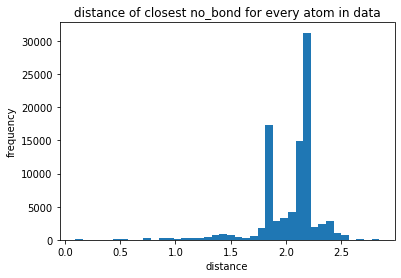

In [30]:
plt.title('distance of closest no_bond for every atom in data')
plt.xlabel('distance')
plt.ylabel('frequency')
plt.hist(total, bins = 40)